In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler #scaling de los datos entre 0 y 1
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from os import listdir
from os.path import isfile, join
plt.style.use('seaborn')
plt.style.use('matplotlibrc.py')

Using TensorFlow backend.


In [2]:
  dic_localidades = {
        'RiesgoBariloche':'Bariloche',
        'RiesgoBuenosAires':'Buenos Aires',
        'RiesgoCABACABANA':'CABA',
        'RiesgoChacoNA':'Chaco',
        'RiesgoCórdobaCórdoba':'Córdoba',
        'RiesgoEntreRiosRíos':'Entre Ríos',
        'RiesgoJujuyJujuy':'Jujuy',
        'RiesgoLaRiojaRioja':'La Rioja',
        'RiesgoMendozaMendoza':'Mendoza',
        'RiesgoNeuquénNeuquén':'Neuquén',
        'RiesgoRioNegro':'Río Negro',
        'RiesgoSaltaSalta':'Salta',
        'RiesgoSantaCruzSantaCruz':'Santa Cruz',
        'RiesgoSantaFeSantaFe':'Santa Fe',
        'RiesgoTierradelFuegoTierradel':'Tierra del Fuego',
        'RiesgoTucumanTucuman':'Tucumán'
    }

In [3]:
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		if out_end_ix > len(sequence):
			break
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [4]:
def graph_predictions(l,df_original,y_train_pr,y_test_pr,name):
    plt.plot(df_original) 
    months_tr = np.arange(l,len(y_train_pr)+l) #meses de training
    months_ts = np.arange(len(y_train_pr)+(2*l)+1,len(df_original)-1) #meses de testing
    plt.plot(months_tr,y_train_pr,label='train') #grafico de train results
    plt.plot(months_ts,y_test_pr,label='test') #grafico de test results
    plt.title(dic_localidades[str(name)])
    plt.xlabel('Días')
    plt.ylabel('Casos/100 mil hab')
    plt.legend(fontsize=12)
    plt.savefig(dic_localidades[str(name)]+'_fit_2.pdf')
    plt.show()

In [5]:
seed = 7
np.random.seed(seed)

In [6]:
mypath = 'Datos'
files = [f for f in listdir(mypath) if isfile(join(mypath, f))] #get all file names of that path
df_train_total = [] #aca guardamos todos los datos

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
n_steps_in = 5
n_steps_out = 5

# armo scaler para los datos

In [8]:
for file in files:
    print(file)
    data = pd.read_csv(mypath+str('/')+file,sep=",",quotechar='"',na_values=[''])
    data = data["incidenciaAcum14d"]
    df = pd.DataFrame(data)
    df = df.to_numpy()
    df = df[:-20]
    total_size = df.shape[0]
    train_size = int(0.8*total_size)
    test_size = total_size - train_size
    train_data = df[:-test_size]
    df_train_total.extend(list(train_data.flatten()))

RiesgoBariloche
RiesgoBuenosAires
RiesgoCABACABANA
RiesgoChacoNA
RiesgoCórdobaCórdoba
RiesgoEntreRiosRíos
RiesgoJujuyJujuy
RiesgoLaRiojaRioja
RiesgoMendozaMendoza
RiesgoNeuquénNeuquén
RiesgoRioNegro
RiesgoSaltaSalta
RiesgoSantaCruzSantaCruz
RiesgoSantaFeSantaFe
RiesgoTierradelFuegoTierradel
RiesgoTucumanTucuman


In [9]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_train_total = scaler.fit_transform(np.array(df_train_total).reshape(-1,1))

# ahora armo los datos de train, test y forecast

In [10]:
df_forecast = [] #aca van a estar los datos para hacer el forecasting

In [11]:
for file in files:
    print(file)
    data = pd.read_csv(mypath+str('/')+file,sep=",",quotechar='"',na_values=[''])
    data = data["incidenciaAcum14d"]
    df = pd.DataFrame(data)
    df = df.to_numpy()
    df_forecast.append(df[-20:-10])
    df = df[:-20]
    total_size = df.shape[0]
    train_size = int(0.8*total_size)
    test_size = total_size - train_size
    train_data = df[:-test_size]
    test_data = df[-test_size:]
    train_data = scaler.transform(train_data.reshape(-1,1))
    test_data = scaler.transform(test_data.reshape(-1,1))
    if file == 'RiesgoBariloche':
        x_train_total, y_train_total = split_sequence(train_data, n_steps_in, n_steps_out)
        x_test_total, y_test_total = split_sequence(test_data, n_steps_in, n_steps_out)
    else:
        #train
        x_train, y_train = split_sequence(train_data, n_steps_in, n_steps_out)
        x_train_total = np.vstack((x_train_total,x_train))
        y_train_total = np.vstack((y_train_total,y_train))
        #test
        x_test, y_test = split_sequence(test_data, n_steps_in, n_steps_out)
        x_test_total = np.vstack((x_test_total,x_test))
        y_test_total = np.vstack((y_test_total,y_test))
            

RiesgoBariloche
RiesgoBuenosAires
RiesgoCABACABANA
RiesgoChacoNA
RiesgoCórdobaCórdoba
RiesgoEntreRiosRíos
RiesgoJujuyJujuy
RiesgoLaRiojaRioja
RiesgoMendozaMendoza
RiesgoNeuquénNeuquén
RiesgoRioNegro
RiesgoSaltaSalta
RiesgoSantaCruzSantaCruz
RiesgoSantaFeSantaFe
RiesgoTierradelFuegoTierradel
RiesgoTucumanTucuman


In [12]:
x_train_total = x_train_total.reshape(x_train_total.shape[0],1,x_train_total.shape[1])
x_test_total = x_test_total.reshape(x_test_total.shape[0],1,x_test_total.shape[1])
y_train_total =  y_train_total.reshape(y_train_total.shape[0],y_train_total.shape[1])
y_test_total = y_test_total.reshape(y_test_total.shape[0],y_test_total.shape[1])

In [13]:
model = keras.Sequential()
model.add(keras.layers.Bidirectional(keras.layers.LSTM(units=64,activation='relu',input_shape=(1,n_steps_in))))
model.add(keras.layers.Dense(units=n_steps_out))
model.compile(optimizer='adam',loss=keras.losses.MSE,metrics=['mse']) 
history = model.fit(x_train_total, y_train_total,epochs=500,batch_size=512,validation_data=(x_test_total,y_test_total),verbose=2) 

Train on 3398 samples, validate on 750 samples
Epoch 1/500
 - 1s - loss: 0.0448 - mse: 0.0448 - val_loss: 0.9018 - val_mse: 0.9018
Epoch 2/500
 - 0s - loss: 0.0384 - mse: 0.0384 - val_loss: 0.7693 - val_mse: 0.7693
Epoch 3/500
 - 0s - loss: 0.0322 - mse: 0.0322 - val_loss: 0.6206 - val_mse: 0.6206
Epoch 4/500
 - 0s - loss: 0.0257 - mse: 0.0257 - val_loss: 0.4616 - val_mse: 0.4616
Epoch 5/500
 - 0s - loss: 0.0201 - mse: 0.0201 - val_loss: 0.2997 - val_mse: 0.2997
Epoch 6/500
 - 0s - loss: 0.0148 - mse: 0.0148 - val_loss: 0.1632 - val_mse: 0.1632
Epoch 7/500
 - 0s - loss: 0.0106 - mse: 0.0106 - val_loss: 0.0766 - val_mse: 0.0766
Epoch 8/500
 - 0s - loss: 0.0073 - mse: 0.0073 - val_loss: 0.0521 - val_mse: 0.0521
Epoch 9/500
 - 0s - loss: 0.0047 - mse: 0.0047 - val_loss: 0.0832 - val_mse: 0.0832
Epoch 10/500
 - 0s - loss: 0.0030 - mse: 0.0030 - val_loss: 0.1443 - val_mse: 0.1443
Epoch 11/500
 - 0s - loss: 0.0020 - mse: 0.0020 - val_loss: 0.2022 - val_mse: 0.2022
Epoch 12/500
 - 0s - loss: 

Epoch 92/500
 - 0s - loss: 3.4865e-04 - mse: 3.4865e-04 - val_loss: 0.0149 - val_mse: 0.0149
Epoch 93/500
 - 0s - loss: 3.3875e-04 - mse: 3.3875e-04 - val_loss: 0.0146 - val_mse: 0.0146
Epoch 94/500
 - 0s - loss: 3.2945e-04 - mse: 3.2945e-04 - val_loss: 0.0147 - val_mse: 0.0147
Epoch 95/500
 - 0s - loss: 3.2044e-04 - mse: 3.2044e-04 - val_loss: 0.0147 - val_mse: 0.0147
Epoch 96/500
 - 0s - loss: 3.1085e-04 - mse: 3.1085e-04 - val_loss: 0.0142 - val_mse: 0.0142
Epoch 97/500
 - 0s - loss: 3.0280e-04 - mse: 3.0280e-04 - val_loss: 0.0141 - val_mse: 0.0141
Epoch 98/500
 - 0s - loss: 2.9569e-04 - mse: 2.9569e-04 - val_loss: 0.0144 - val_mse: 0.0144
Epoch 99/500
 - 0s - loss: 2.8795e-04 - mse: 2.8795e-04 - val_loss: 0.0140 - val_mse: 0.0140
Epoch 100/500
 - 0s - loss: 2.8133e-04 - mse: 2.8133e-04 - val_loss: 0.0139 - val_mse: 0.0139
Epoch 101/500
 - 0s - loss: 2.7531e-04 - mse: 2.7531e-04 - val_loss: 0.0139 - val_mse: 0.0139
Epoch 102/500
 - 0s - loss: 2.6790e-04 - mse: 2.6790e-04 - val_loss:

Epoch 180/500
 - 0s - loss: 1.7594e-04 - mse: 1.7594e-04 - val_loss: 0.0216 - val_mse: 0.0216
Epoch 181/500
 - 0s - loss: 1.7499e-04 - mse: 1.7499e-04 - val_loss: 0.0219 - val_mse: 0.0219
Epoch 182/500
 - 0s - loss: 1.7692e-04 - mse: 1.7692e-04 - val_loss: 0.0215 - val_mse: 0.0215
Epoch 183/500
 - 0s - loss: 1.7501e-04 - mse: 1.7501e-04 - val_loss: 0.0219 - val_mse: 0.0219
Epoch 184/500
 - 0s - loss: 1.7610e-04 - mse: 1.7610e-04 - val_loss: 0.0222 - val_mse: 0.0222
Epoch 185/500
 - 0s - loss: 1.7939e-04 - mse: 1.7939e-04 - val_loss: 0.0208 - val_mse: 0.0208
Epoch 186/500
 - 0s - loss: 1.7808e-04 - mse: 1.7808e-04 - val_loss: 0.0219 - val_mse: 0.0219
Epoch 187/500
 - 0s - loss: 1.7578e-04 - mse: 1.7578e-04 - val_loss: 0.0225 - val_mse: 0.0225
Epoch 188/500
 - 0s - loss: 1.7372e-04 - mse: 1.7372e-04 - val_loss: 0.0209 - val_mse: 0.0209
Epoch 189/500
 - 0s - loss: 1.7554e-04 - mse: 1.7554e-04 - val_loss: 0.0220 - val_mse: 0.0220
Epoch 190/500
 - 0s - loss: 1.7456e-04 - mse: 1.7456e-04 - v

Epoch 268/500
 - 0s - loss: 1.6539e-04 - mse: 1.6539e-04 - val_loss: 0.0220 - val_mse: 0.0220
Epoch 269/500
 - 0s - loss: 1.6577e-04 - mse: 1.6577e-04 - val_loss: 0.0234 - val_mse: 0.0234
Epoch 270/500
 - 0s - loss: 1.6737e-04 - mse: 1.6737e-04 - val_loss: 0.0228 - val_mse: 0.0228
Epoch 271/500
 - 0s - loss: 1.6577e-04 - mse: 1.6577e-04 - val_loss: 0.0223 - val_mse: 0.0223
Epoch 272/500
 - 0s - loss: 1.6595e-04 - mse: 1.6595e-04 - val_loss: 0.0213 - val_mse: 0.0213
Epoch 273/500
 - 0s - loss: 1.6893e-04 - mse: 1.6893e-04 - val_loss: 0.0231 - val_mse: 0.0231
Epoch 274/500
 - 0s - loss: 1.6508e-04 - mse: 1.6508e-04 - val_loss: 0.0224 - val_mse: 0.0224
Epoch 275/500
 - 0s - loss: 1.6478e-04 - mse: 1.6478e-04 - val_loss: 0.0218 - val_mse: 0.0218
Epoch 276/500
 - 0s - loss: 1.6485e-04 - mse: 1.6485e-04 - val_loss: 0.0234 - val_mse: 0.0234
Epoch 277/500
 - 0s - loss: 1.6646e-04 - mse: 1.6646e-04 - val_loss: 0.0226 - val_mse: 0.0226
Epoch 278/500
 - 0s - loss: 1.6476e-04 - mse: 1.6476e-04 - v

Epoch 356/500
 - 0s - loss: 1.5836e-04 - mse: 1.5836e-04 - val_loss: 0.0246 - val_mse: 0.0246
Epoch 357/500
 - 0s - loss: 1.5839e-04 - mse: 1.5839e-04 - val_loss: 0.0227 - val_mse: 0.0227
Epoch 358/500
 - 0s - loss: 1.5856e-04 - mse: 1.5856e-04 - val_loss: 0.0221 - val_mse: 0.0221
Epoch 359/500
 - 0s - loss: 1.5931e-04 - mse: 1.5931e-04 - val_loss: 0.0230 - val_mse: 0.0230
Epoch 360/500
 - 0s - loss: 1.5675e-04 - mse: 1.5675e-04 - val_loss: 0.0225 - val_mse: 0.0225
Epoch 361/500
 - 0s - loss: 1.5844e-04 - mse: 1.5844e-04 - val_loss: 0.0244 - val_mse: 0.0244
Epoch 362/500
 - 0s - loss: 1.5738e-04 - mse: 1.5738e-04 - val_loss: 0.0231 - val_mse: 0.0231
Epoch 363/500
 - 0s - loss: 1.5696e-04 - mse: 1.5696e-04 - val_loss: 0.0247 - val_mse: 0.0247
Epoch 364/500
 - 0s - loss: 1.5832e-04 - mse: 1.5832e-04 - val_loss: 0.0230 - val_mse: 0.0230
Epoch 365/500
 - 0s - loss: 1.5655e-04 - mse: 1.5655e-04 - val_loss: 0.0231 - val_mse: 0.0231
Epoch 366/500
 - 0s - loss: 1.5682e-04 - mse: 1.5682e-04 - v

Epoch 444/500
 - 0s - loss: 1.5163e-04 - mse: 1.5163e-04 - val_loss: 0.0249 - val_mse: 0.0249
Epoch 445/500
 - 0s - loss: 1.5034e-04 - mse: 1.5034e-04 - val_loss: 0.0231 - val_mse: 0.0231
Epoch 446/500
 - 0s - loss: 1.5111e-04 - mse: 1.5111e-04 - val_loss: 0.0241 - val_mse: 0.0241
Epoch 447/500
 - 0s - loss: 1.5299e-04 - mse: 1.5299e-04 - val_loss: 0.0234 - val_mse: 0.0234
Epoch 448/500
 - 0s - loss: 1.5565e-04 - mse: 1.5565e-04 - val_loss: 0.0273 - val_mse: 0.0273
Epoch 449/500
 - 0s - loss: 1.5587e-04 - mse: 1.5587e-04 - val_loss: 0.0239 - val_mse: 0.0239
Epoch 450/500
 - 0s - loss: 1.5272e-04 - mse: 1.5272e-04 - val_loss: 0.0242 - val_mse: 0.0242
Epoch 451/500
 - 0s - loss: 1.5271e-04 - mse: 1.5271e-04 - val_loss: 0.0239 - val_mse: 0.0239
Epoch 452/500
 - 0s - loss: 1.5161e-04 - mse: 1.5161e-04 - val_loss: 0.0243 - val_mse: 0.0243
Epoch 453/500
 - 0s - loss: 1.5030e-04 - mse: 1.5030e-04 - val_loss: 0.0255 - val_mse: 0.0255
Epoch 454/500
 - 0s - loss: 1.4793e-04 - mse: 1.4793e-04 - v

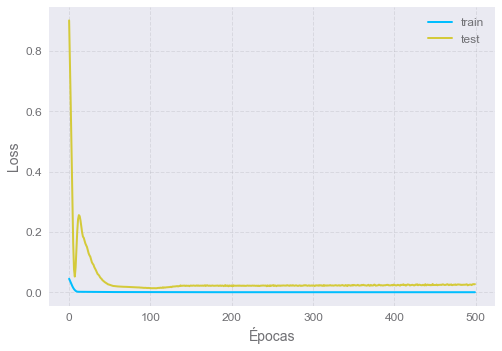

In [14]:
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend(fontsize=12)

In [15]:
y_train_pr = model.predict(x_train_total)
y_test_pr = model.predict(x_test_total)
y_train_pr = scaler.inverse_transform(y_train_pr)
y_test_pr = scaler.inverse_transform(y_test_pr)
y_train =  scaler.inverse_transform(y_train_total)
y_test = scaler.inverse_transform(y_test_total)
print('train mse squared:',mean_squared_error(y_train_total,y_train)) 
print('test mse squared:',mean_squared_error(y_test_total,y_test)) 

train mse squared: 17799.54158506607
test mse squared: 390196.5737701409


# veo como se ajustan a los train y test data para distintas localidades

RiesgoBariloche


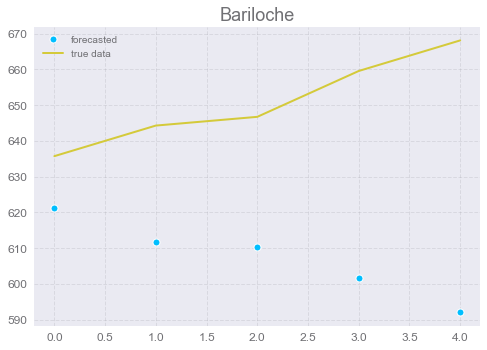

RiesgoBuenosAires


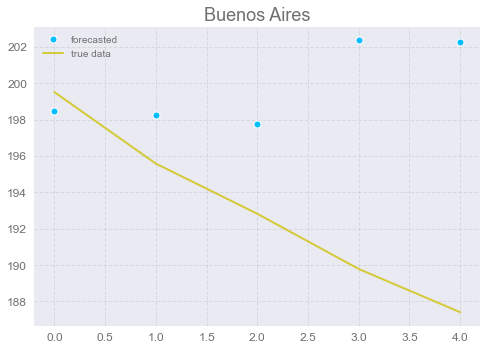

RiesgoCABACABANA


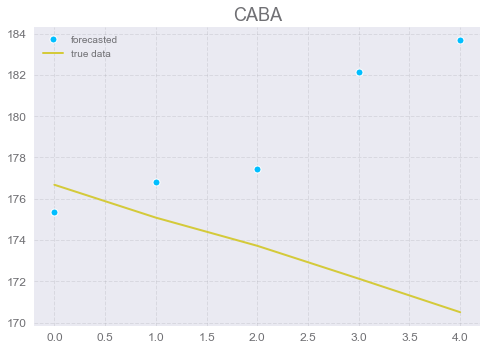

RiesgoChacoNA


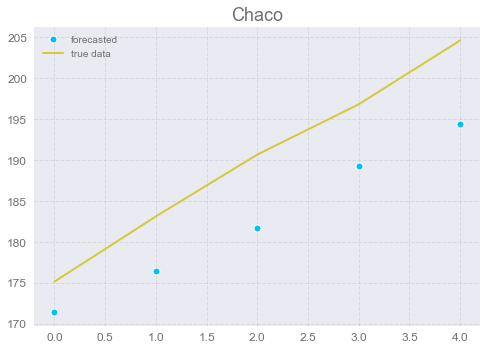

RiesgoCórdobaCórdoba


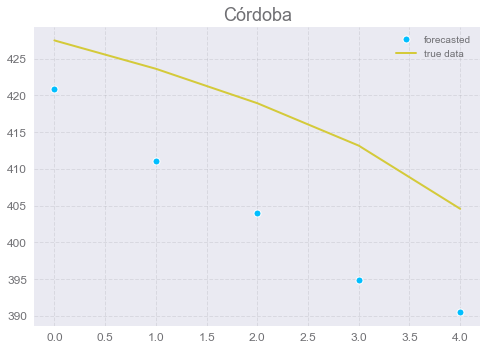

RiesgoEntreRiosRíos


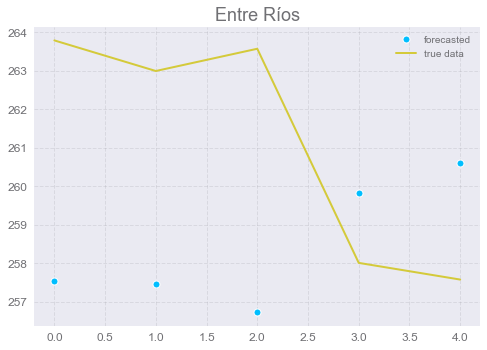

RiesgoJujuyJujuy


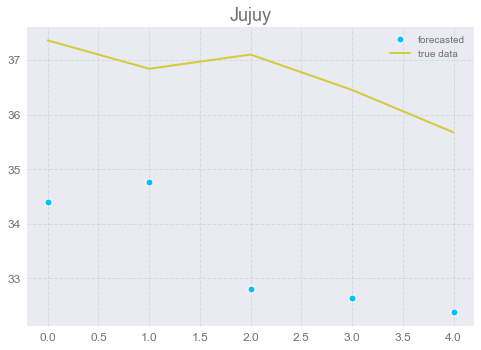

RiesgoLaRiojaRioja


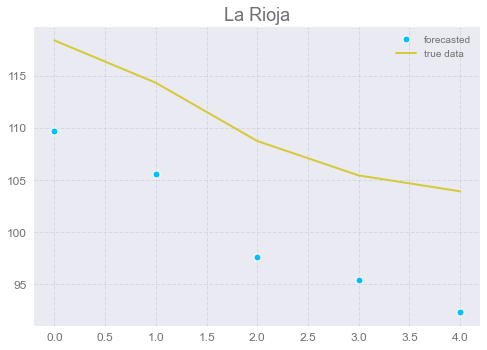

RiesgoMendozaMendoza


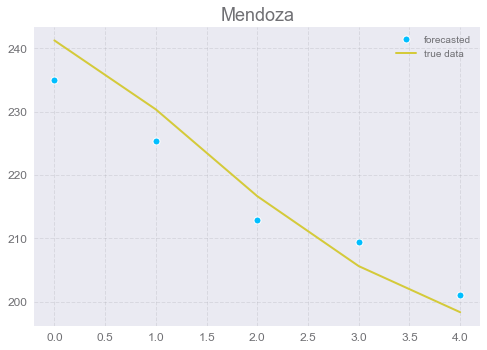

RiesgoNeuquénNeuquén


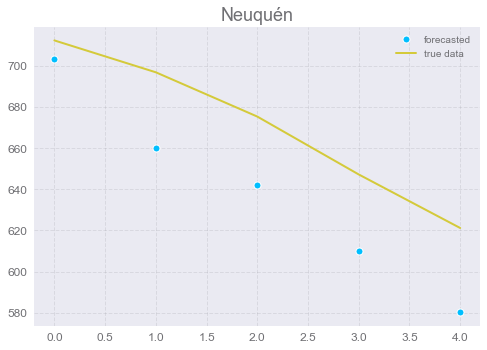

RiesgoRioNegro


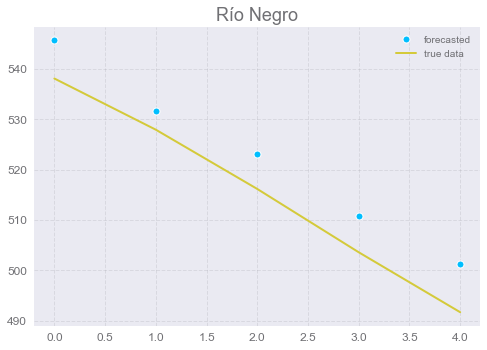

RiesgoSaltaSalta


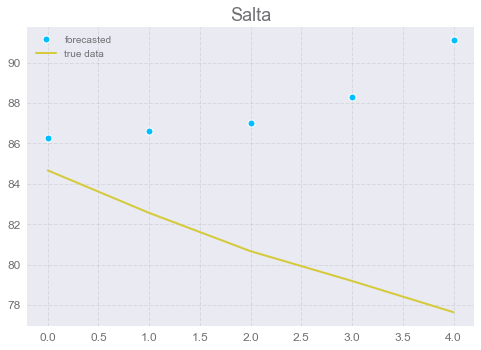

RiesgoSantaCruzSantaCruz


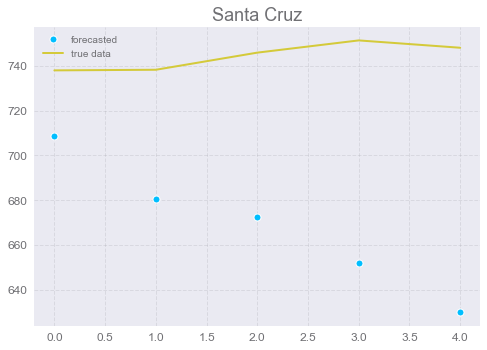

RiesgoSantaFeSantaFe


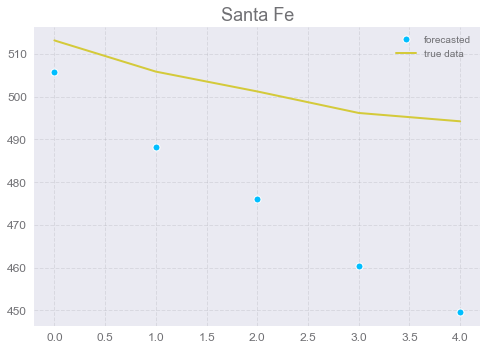

RiesgoTierradelFuegoTierradel


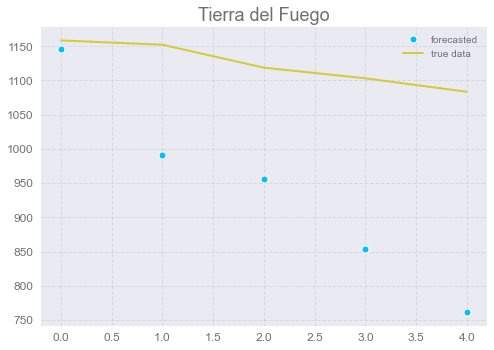

RiesgoTucumanTucuman


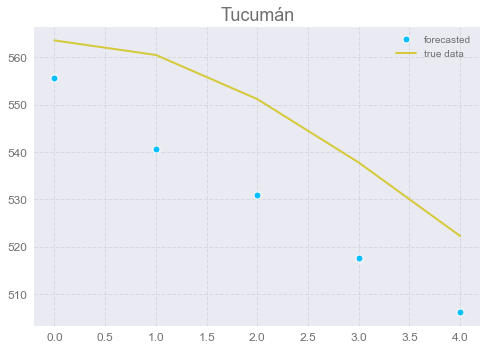

In [16]:
for file in files:
    print(file)
    data = pd.read_csv(mypath+str('/')+file,sep=",",quotechar='"',na_values=[''])
    data = data["incidenciaAcum14d"]
    df = pd.DataFrame(data)
    df = df.to_numpy()
    df = df[:-10]
    y_forecast = np.copy(df[-n_steps_in:])
    df = df[:-n_steps_in]
    x_toforecast = np.copy(df[-n_steps_in:])
    x_toforecast = scaler.transform(x_toforecast.reshape(-1,1))
    x_toforecast = x_toforecast.flatten()
    x_toforecast = x_toforecast.reshape(1,1,n_steps_in)
    y_forecasted = model.predict(x_toforecast)
    y_forecasted = scaler.inverse_transform(y_forecasted)
    plt.title(dic_localidades[str(file)])
    plt.plot(y_forecasted.flatten(),'o',label='forecasted')
    plt.plot(y_forecast,label='true data')
    plt.legend()
    plt.show()